# Stereo Panning Spectrum

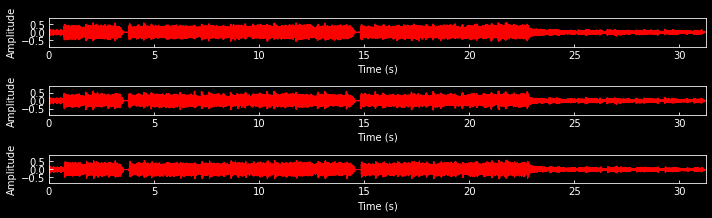

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
plt.style.use('dark_background')

#1. Load and plot each channel of the stereo file
    #Load
filename = 'supervixen.wav'#'SinguhrI/Audio/001 Erwin Stache - Klangkasten.wav' #'Runawaytest.wav'
y, sr = librosa.load(filename, mono=False)
t = np.arange(y.shape[1]) / sr

    #plot
plt.figure(figsize=(10,3))

# plot left channel
plt.subplot(3, 1, 1)
plt.plot(t, y[0], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])
 
#plot right channel
plt.subplot(3, 1, 2)
plt.plot(t, y[1], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])

#plot stereo
plt.subplot(3, 1, 3)
librosa.display.waveplot(y, sr=sr, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.9, 0.9])

plt.tight_layout()



"If we denote STFT of the left, right signals $X1(t)$, $Xr(t)$ for a particular analysis window $Xl(k)$, $Xr(k)$, where $k$  the frequency index, we can define the following similarity measure:

$$ V = 2 * \frac{|Xl(k)Xr^*(k)|} {|Xl(k)|^2 + |Xr(k)|^2}$$

Where $*$ denotes complex conjugation." 

(-0.51, 0.51)

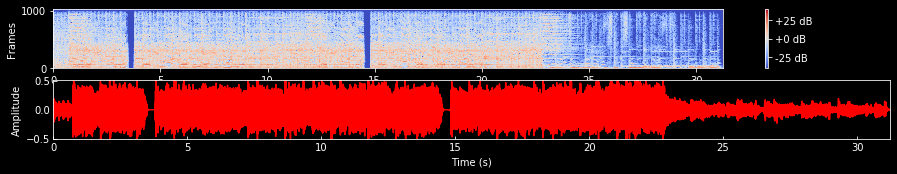

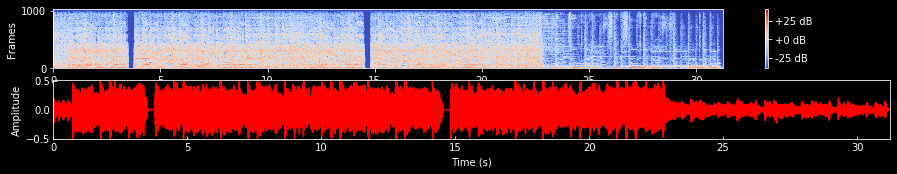

In [41]:

#as fortranarray?
y_left=np.asfortranarray(y[0])
y_right=np.asfortranarray(y[1])

#y_left=y[0]
#y_right=y[1]

#apply stft to each channel

stft_left = librosa.stft(y_left) 
stft_right = librosa.stft(y_right) 

#Plot stft

# plot left channel
S_left = librosa.amplitude_to_db(abs(stft_left))## To log scale
plt.figure(figsize=(15, 5))
plt.subplot(4, 1, 1)
librosa.display.specshow(S_left, sr=sr, x_axis='time', y_axis='frames')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4, 1, 2)
plt.plot(t, y[0], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.51, 0.51])


# plot right channel
S_right = librosa.amplitude_to_db(abs(stft_right))## To log scale
plt.figure(figsize=(15, 5))
plt.subplot(4, 1, 3)
librosa.display.specshow(S_right, sr=sr, x_axis='time', y_axis='frames')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4, 1, 4)
plt.plot(t, y[1], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tick_params(direction='in')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.51, 0.51])



(170.0973+78.524155j)
(-897.7884-124.979454j)


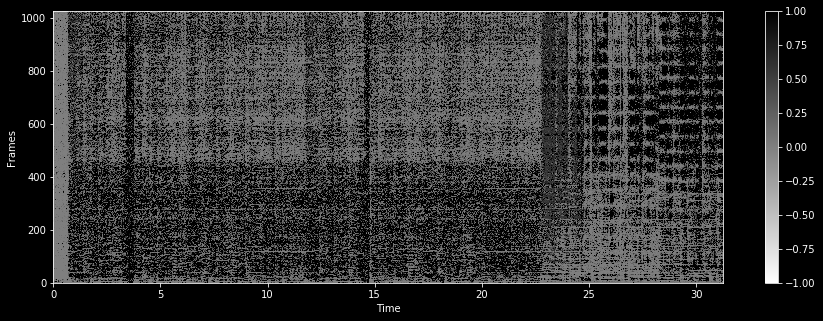

In [48]:
##### Define functions and equations

def similarity(stft_left, stft_right): ## Equation [1]
    num = np.multiply(stft_left,stft_right) 
    den = np.add(np.square(stft_left), np.square(stft_right))    
    sim = np.divide(num, den) 
    return np.multiply(2,sim)

def similarity_left(stft_left, stft_right):  #Equation [3]
    num = np.multiply(stft_left,stft_right)
    den = np.square(stft_left)
    sim_left = np.divide(num, den) 
    return sim_left
  
def similarity_right(stft_left, stft_right): #Equation [3]
    num = np.multiply(stft_left, stft_right)
    den = np.square(stft_right)
    sim_right = np.divide(num, den) 
    return sim_right

Vl = similarity_left(stft_left, stft_right) #Equation [3]
Vr = similarity_right(stft_left, stft_right) #Equation [3]
V = similarity(stft_left, stft_right) ## Equation [1]

def delta(Vl, Vr): #Equation [4]
    return np.subtract(Vl, Vr) 

var_delta = delta(Vl, Vr) #Equation [4]

def delta_amb(var_delta): #Equation[5] 
    con1 = np.where(var_delta < 0, 1, var_delta)
    con2 = np.where(con1 > 0, -1, con1)
    con3 = np.where(con2 == 0, 0, con2)
    return con3

var_delta_amb = delta_amb(var_delta) #Equation[5]

def SPS(V, var_delta_amb): #Equation[6]
    sps = np.multiply(np.subtract(1, V), var_delta_amb)
    return sps

sps = SPS(V, var_delta_amb) #Equation[6]

#plot V
#sps_clip = np.clip(sps, -1.0, 1.0)
#sps_db = librosa.amplitude_to_db(sps)
#sps_pcen = librosa.pcen(sps * (2**31))
print(np.amax(sps))
print(np.amin(sps))

plt.figure(figsize=(15, 5))
librosa.display.specshow(sps, x_axis='time', y_axis="frames", cmap="gray_r", vmin=-1.0, vmax= 1.0)
plt.colorbar()
# plot left channel


